In [1]:
from sklearn.neighbors import NearestNeighbors
import re
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import seaborn as sns
import xarray as xr
from glob import glob
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.path import Path

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Read in the cell data

In [2]:
local_data_path = "/Users/mrs.zhuang/Documents/Msc_Machine_Learning/Final_Project"

In [3]:
fn = os.path.join(local_data_path, "Merge_cell_seg_data.txt")
#/Users/mrs.zhuang/Documents/Msc_Machine_Learning/Final_Project/Merge_cell_seg_data.feather.txt 
# pd.read_csv(fn, sep="\t")
df_all = pd.read_csv(fn, sep="\t")
feather_fn = fn.replace(".txt", ".feather")
df_all.to_feather(feather_fn)
df_all = pd.read_feather(feather_fn)

In [4]:
df_all.head(5)

,Path,Sample Name,Tissue Category,Phenotype,Cell ID,Total Cells,Tissue Category Area (square microns),Cell Density (per square mm),Cell X Position,Cell Y Position,...,"Entire Cell Autofluorescence Total (Normalized Counts, Total Weighting)",Lab ID,Slide ID,Annotation ID,TMA Sector,TMA Row,TMA Column,TMA Field,Confidence,inForm 2.8.0.17499
0,F:\For Inform analysis Fusion\Final staining\E...,Eric recsan block 1 opt white slide_Scan1.qptiff,stroma,CD3+,1208,NaN,NaN,NaN,6484.8,30805.3,...,3208.091,NaN,Eric recsan block 1 opt white slide_Scan1,Eric recsan block 1 opt white slide_Scan1_Core...,1,1,B,1,53.22%,NaN
1,F:\For Inform analysis Fusion\Final staining\E...,Eric recsan block 1 opt white slide_Scan1.qptiff,epithelium,CK+,1209,NaN,NaN,NaN,6492.7,30818.3,...,2130.160,NaN,Eric recsan block 1 opt white slide_Scan1,Eric recsan block 1 opt white slide_Scan1_Core...,1,1,B,1,49.62%,NaN
2,F:\For Inform analysis Fusion\Final staining\E...,Eric recsan block 1 opt white slide_Scan1.qptiff,epithelium,CD3+,1210,NaN,NaN,NaN,6643.8,30838.2,...,3093.135,NaN,Eric recsan block 1 opt white slide_Scan1,Eric recsan block 1 opt white slide_Scan1_Core...,1,1,B,1,99.92%,NaN
3,F:\For Inform analysis Fusion\Final staining\E...,Eric recsan block 1 opt white slide_Scan1.qptiff,epithelium,CD3+,1211,NaN,NaN,NaN,6488.8,30842.7,...,4283.445,NaN,Eric recsan block 1 opt white slide_Scan1,Eric recsan block 1 opt white slide_Scan1_Core...,1,1,B,1,80.22%,NaN
4,F:\For Inform analysis Fusion\Final staining\E...,Eric recsan block 1 opt white slide_Scan1.qptiff,epithelium,CD3+,1212,NaN,NaN,NaN,6568.5,30847.2,...,4969.452,NaN,Eric recsan block 1 opt white slide_Scan1,Eric recsan block 1 opt white slide_Scan1_Core...,1,1,B,1,35.57%,NaN


In [ ]:
annotation_ids = df_all["Annotation ID"].unique()

In [ ]:
i = 251
annotation_id = annotation_ids[i]
print(annotation_id)
select = df_all['Annotation ID'] == "bl 9 ws inform_Scan2_Core[1,10,A]_[8748,54246]"
df = df_all[select].copy()

Eric 5 inform_Scan1_Core[1,11,B]_[11159,48212]


In [ ]:
df_all["Phenotype"].unique()

array(['CD3+', 'CK+', 'Double_positive_CD64+CD68+',
       'Triple_positive_CD64+CD68+TREM-1+', 'Triple_CD64+CD68+CD163+',
       'Single_TREM-1+', 'other+', 'Double_TREM-1+CD68+',
       'Q_CD64+CD68+CD163+TREM-1+', None], dtype=object)

In [ ]:
df_all["Tissue Category"].unique()

array(['stroma', 'epithelium', 'other'], dtype=object)

## Plot cell positions coloured by phenotype

In [ ]:
df['x'] = df["Cell X Position"] - df["Cell X Position"].mean()
df['y'] = df["Cell Y Position"] - df["Cell Y Position"].mean()

In [ ]:
radius = 599
background = [[0.9, 0.9, 0.9]]

In [ ]:
phenotype_colours = {'CK+': 'blue',
                     'Single_TREM-1+': 'cyan',
                     'CD3+': 'red',
                     'Double_positive_CD64+CD68+': 'limegreen',
                     'Double_TREM-1+CD68+': 'magenta',
                     'Triple_CD64+CD68+CD163+': 'purple',
                     'Triple_positive_CD64+CD68+TREM-1+': 'brown',
                     'Q_CD64+CD68+CD163+TREM-1+': 'gold',
                     'other+': 'black',
                     None: 'lightgrey'}

phenotypes = phenotype_colours.keys()

phenotype_names = {p: 'negative' if p is None else re.sub('Single_|Double_|Triple_|Q_|positive_', '', p) for p in phenotypes}

In [ ]:
def plot_separate(show_tissue=True, tissue_dot_size=100):
    fig, axarr = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
    for i, p in enumerate([p for p in phenotypes if p is not None]):
        ax = axarr.flat[i]
        dfp = df[df["Phenotype"] == p]
        if show_tissue:        
            dfe = df[df["Tissue Category"] == "epithelium"]
            dfs = df[df["Tissue Category"] == "stroma"]
            dfo = df[df["Tissue Category"] == "other"]
            ax.scatter(dfo["x"], -dfo["y"], marker='.', c='lightgrey', edgecolor='none', s=tissue_dot_size)
            ax.scatter(dfs["x"], -dfs["y"], marker='.', c='lightgreen', edgecolor='none', s=tissue_dot_size)
            ax.scatter(dfe["x"], -dfe["y"], marker='.', c='pink', edgecolor='none', s=tissue_dot_size)
        ax.scatter(df["x"], -df["y"], marker='.', c='darkgrey', s=5)
        ax.scatter(dfp["x"], -dfp["y"], marker='.', c=phenotype_colours[p], s=5, label=phenotype_names[p])
        #ax.set_xlim(-radius, radius)
        #ax.set_ylim(-radius, radius)
        ax.set_aspect("equal")
        ax.legend(loc="lower right", fontsize="small")
    fig.tight_layout()

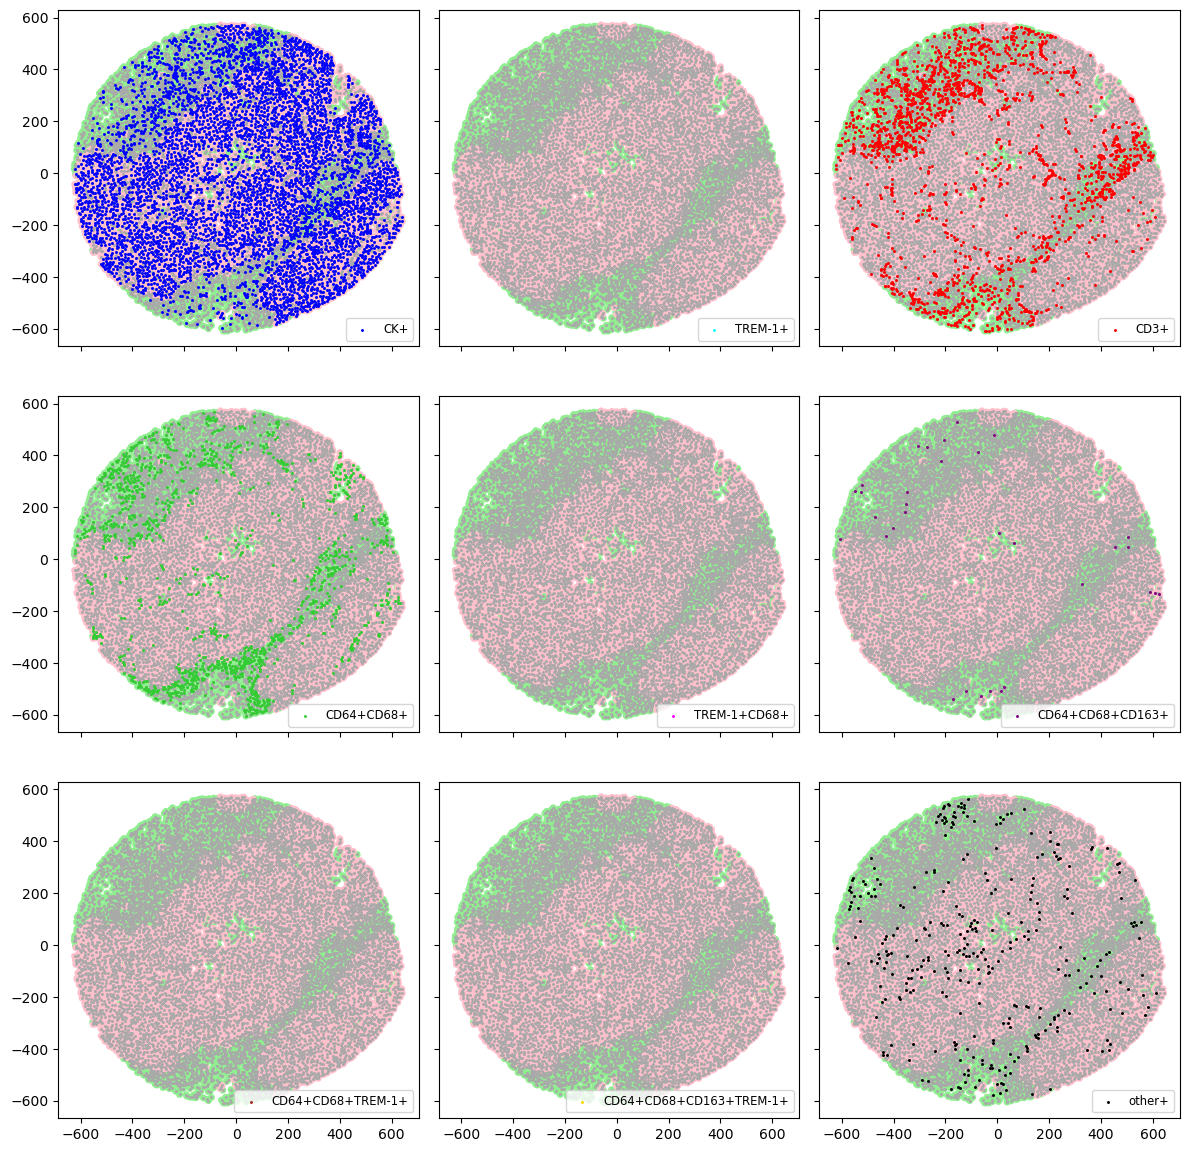

In [ ]:
plot_separate()

In [ ]:
def plot_overlaid(randoms=None, show_tissue=True, tissue_dot_size=200):
    fig, ax = plt.subplots(figsize=(10, 5))
    if show_tissue:
        dfe = df[df["Tissue Category"] == "epithelium"]
        dfs = df[df["Tissue Category"] == "stroma"]
        dfo = df[df["Tissue Category"] == "other"]
        ax.scatter(dfo["x"], -dfo["y"], marker='.', c='lightgrey', edgecolor='none', s=tissue_dot_size)
        ax.scatter(dfs["x"], -dfs["y"], marker='.', c='lightgreen', edgecolor='none', s=tissue_dot_size)
        ax.scatter(dfe["x"], -dfe["y"], marker='.', c='pink', edgecolor='none', s=tissue_dot_size)
    if randoms is not None:
        ax.scatter(randoms["x"], -randoms["y"], marker=".", c='darkgray', s=3, label="randoms")
    for i, p in enumerate(phenotypes):
        dfp = df[df["Phenotype"] == p]
        ax.scatter(dfp["x"], -dfp["y"], marker=".", c=phenotype_colours[p], s=7, label=phenotype_names[p])
    #ax.set_xlim(-1.1*radius, 1.1*radius)
    #ax.set_ylim(-1.1*radius, 1.1*radius)
    ax.set_aspect("equal")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    fig.tight_layout()

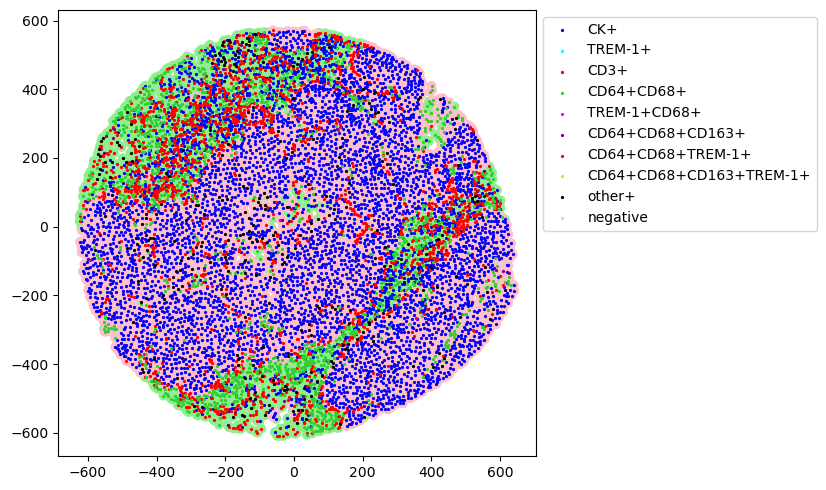

In [ ]:
plot_overlaid()

In [ ]:
def generate_randoms(n, radius, df=None, max_dist=None, hull_margin=None):
    r = radius * np.sqrt(np.random.random(n))
    theta = np.random.random(n) * 2 * np.pi
    dfr = pd.DataFrame()
    dfr["x"] = r * np.cos(theta)
    dfr["y"] = r * np.sin(theta)
    if df is not None:
        nbrs = NearestNeighbors(n_neighbors=1).fit(df[["x", "y"]])
        if max_dist is None:
            self_distances, _ = nbrs.kneighbors()
            max_dist = np.quantile(self_distances, 0.999)
        if hull_margin is None:
            hull_margin = max_dist / 2
        distances, _ = nbrs.kneighbors(dfr)
        dfr = dfr[distances < max_dist]
        hull = ConvexHull(df[["x", "y"]])
        hull_path = Path(df[["x", "y"]].iloc[hull.vertices])
        in_hull = hull_path.contains_points(dfr, radius=hull_margin)
        dfr = dfr[in_hull]
    return dfr

In [ ]:
randoms = generate_randoms(1000000, 1000, df)

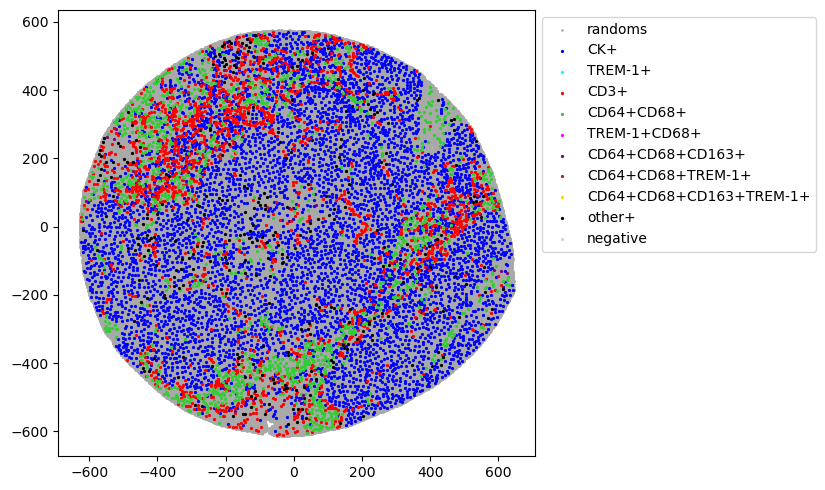

In [ ]:
plot_overlaid(randoms, show_tissue=False)

## A quick look at the 2-point correlation function

Even in this small dataset there are interesting behaviours, although I don't expect they are anything new. However, it gives a taste of what might be possible using these statistics when we go to a full dataset and look at variations between cores and cross-correlations between markers.

In [ ]:
import treecorr

In [ ]:
config = dict(max_sep=2*radius, min_sep=5, nbins=10)
npatch = 10

In [ ]:
dcat = treecorr.Catalog(x=df["x"], y=df["y"])

In [ ]:
dd = treecorr.NNCorrelation(config=config)
dd.process(dcat)

In [ ]:
rcat = treecorr.Catalog(x=randoms["x"], y=randoms["y"])

In [ ]:
rr = treecorr.NNCorrelation(config=config)
rr.process(rcat)
dr = treecorr.NNCorrelation(config=config)
dr.process(dcat, rcat)
dd.calculateXi(rr=rr, dr=dr);

In [ ]:
d10cat = treecorr.Catalog(x=df["x"].sample(frac=0.1), y=df["y"].sample(frac=0.1))
dd10 = treecorr.NNCorrelation(config=config)
dd10.process(d10cat)
dr10 = treecorr.NNCorrelation(config=config)
dr10.process(d10cat, rcat)
dd10.calculateXi(rr=rr, dr=dr10);

This is the 2-point correlation function of all the cells. If the cells were distributed randomly, then this would be zero at all scales. Departures from zero indicate that it is more likely to find pairs of cells at that separation. We can therefore see that:
- at large scales (> 100 microns) the cells are randomly distributed;
- at very small scales (< 6 microns) the cells are anti-correlated, i.e. cells are not found very close together due to their finite size;
- at intermediate scales the cells are spatially correlated, they tend to be clustered together.

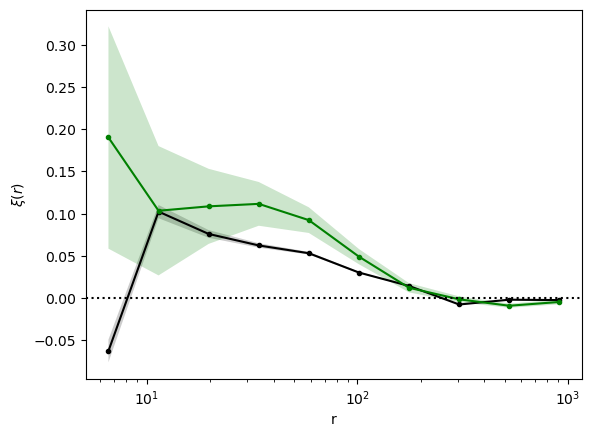

In [ ]:
plt.plot(dd.rnom, dd.xi, 'k.-');
plt.fill_between(dd.rnom, dd.xi - np.sqrt(dd.varxi), dd.xi + np.sqrt(dd.varxi), color='k', edgecolor='none', alpha=0.2)
plt.plot(dd10.rnom, dd10.xi, 'g.-');
plt.fill_between(dd10.rnom, dd10.xi - np.sqrt(dd10.varxi), dd10.xi + np.sqrt(dd10.varxi), color='g', edgecolor='none', alpha=0.2)
plt.axhline(0, ls=":", color="k")
plt.xscale("log")
plt.xlabel("r")
plt.ylabel(r"$\xi(r)$");

Now we will compare the 2-point correlation functions for cells with different phenotypes.

In [ ]:
mm_rr_xi = {}
for p in [p for p in phenotypes if p is not None]:
    mm = treecorr.NNCorrelation(config=config)
    dfp = df[df["Phenotype"] == p]
    if len(dfp) > 10:
        mcat = treecorr.Catalog(x=dfp["x"], y=dfp["y"])
        mm.process(mcat)
        mr = treecorr.NNCorrelation(config=config)
        mr.process(mcat, rcat)
        xi, varxi = mm.calculateXi(rr=rr, dr=mr)
    else:
        mm = None
    mm_rr_xi[p] = mm

In [ ]:
def autocorrfn(rcat=rcat):
    corr = {}
    for p in [p for p in phenotypes if p is not None]:
        dfp = df[df["Phenotype"] == p]
        if len(dfp) > 10:
            dd = treecorr.NNCorrelation(config=config)
            pcat = treecorr.Catalog(x=dfp["x"], y=dfp["y"])
            dd.process(pcat)
            dr = treecorr.NNCorrelation(config=config)
            dr.process(pcat, rcat)
            rr = treecorr.NNCorrelation(config=config)
            rr.process(rcat)
            dd.calculateXi(rr=rr, dr=dr)
        else:
            dd = None
        corr[p] = dd
    return corr

In [ ]:
def crosscorrfn(rcat=rcat, cross=None):
    corr = {}
    phenotype_label = {v: k for k, v in phenotype_names.items()}
    for p in [p for p in phenotypes if p is not None]:
        dfp = df[df["Phenotype"] == p]
        if cross is not None:
            dfq = df[df["Phenotype"] == phenotype_label[cross]]
        else:
            dfq = df
        if len(dfp) > 10:
            dd = treecorr.NNCorrelation(config=config)
            pcat = treecorr.Catalog(x=dfp["x"], y=dfp["y"])
            qcat = treecorr.Catalog(x=dfq["x"], y=dfq["y"])
            dd.process(pcat, qcat)
            dr = treecorr.NNCorrelation(config=config)
            dr.process(pcat, rcat)
            rd = treecorr.NNCorrelation(config=config)
            rd.process(rcat, qcat)
            rr = treecorr.NNCorrelation(config=config)
            rr.process(rcat)
            dd.calculateXi(rr=rr, dr=dr, rd=rd)
        else:
            dd = None
        corr[p] = dd
    return corr

In [ ]:
pp_rr_xi = autocorrfn(rcat)

In [ ]:
def plot_corr_overlaid(corrs, plot_dd=False):
    fig, ax = plt.subplots()
    if plot_dd:
        ax.plot(dd.rnom, dd.xi, 'k--', label="all");
    for i, (name, corr) in enumerate(corrs.items()):
        if corr is not None:
            plt.axhline(0, ls=":", color="k")
            plt.plot(dd.rnom, corr.xi, '.-', color=phenotype_colours[name], label=phenotype_names[name])
    plt.legend()
    plt.xscale("log")
    plt.xlabel("log(r)")
    plt.ylabel(r"$\xi(r)$");

In [ ]:
def plot_corr_separate(corrs, plot_dd=False):
    fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
    for i, (name, corr) in enumerate(corrs.items()):
        ax = axarr.flat[i]
        r = dd.logr
        ax.axhline(0, ls=":", color="k")
        if plot_dd:
            ax.plot(r, dd.xi, 'k--');
        if corr is not None:
            ax.plot(r, corr.xi, '.-', color=phenotype_colours[name], label=phenotype_names[name])
            ax.fill_between(r, corr.xi - np.sqrt(corr.varxi), corr.xi + np.sqrt(corr.varxi), color=phenotype_colours[name], edgecolor='none', alpha=0.2)
        else:
            ax.plot([], [], '.-', color=phenotype_colours[name], label=phenotype_names[name])
        ax.legend()
        ax.set_xlabel("log(r)")
        ax.set_ylabel(r"$\xi(r)$")
        ax.set_ylim(-1, 3)
    fig.tight_layout()

These are the 2-point correlation functions of each phenotype. 

We can therefore see that:
- most markers are more strongly clustered than all cells;
- some markers, e.g. CD3 and CD163, are more strongly clustered than others;
- the scales on which different marks cluster vary, e.g. DAPI is significantly clustered at larger scales than CD163;
- some markers, e.g. CD64, CD68 and pan-CK, are less clustered than all cells at small separations, i.e. they tend to avoid one another.
- some markers, e.g. TREM-1, are less clustered than all cells at large separations.

The error bars indicate that these behaviours are statistically significant.

One could quantify the strength and scale of clustering by fitting a simple parametric function to the correlation function.

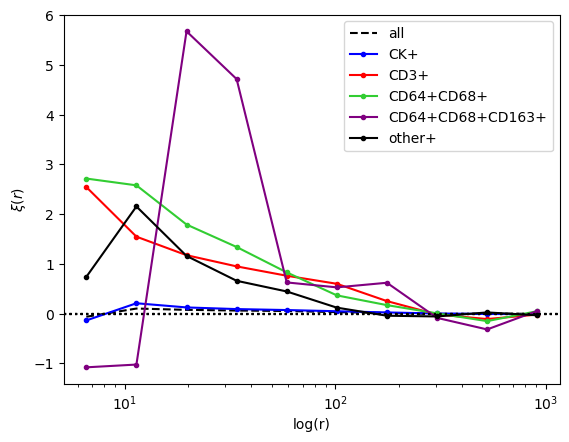

In [ ]:
plot_corr_overlaid(pp_rr_xi, plot_dd=True)

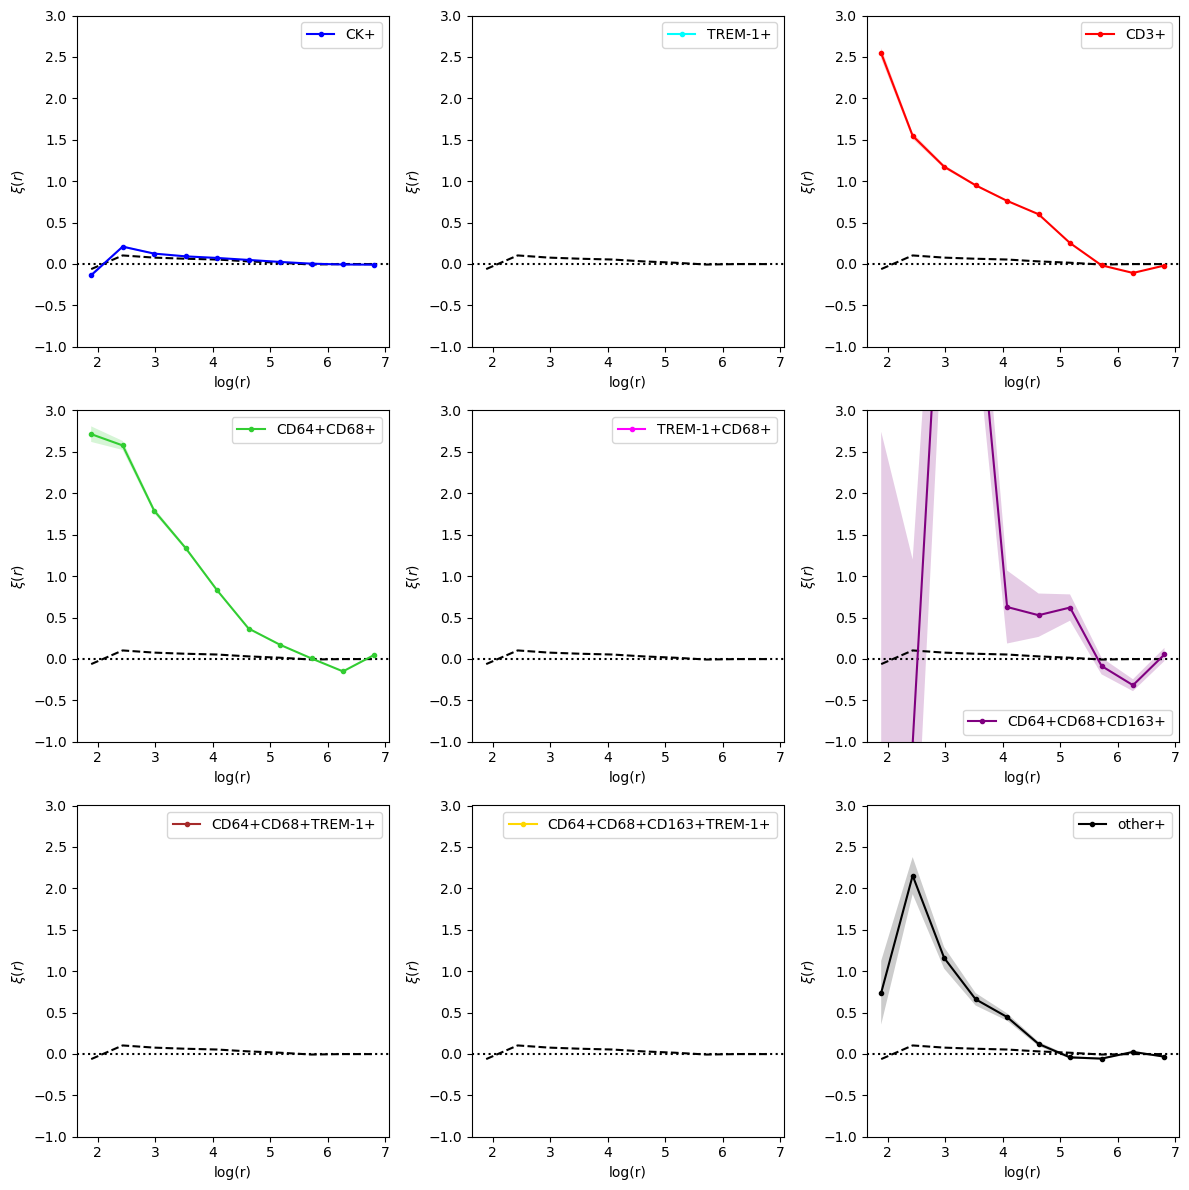

In [ ]:
plot_corr_separate(pp_rr_xi, plot_dd=True)

Rather than compare the pair counts of marked cells to those of a random catalogue, one can compare to all the cells. This indicates how the markers are correlated relative to cells in general.

One could quantify the strength and scale of the relative clustering by fitting a simple parametric function to the correlation function.

In [ ]:
pp_dd_xi = autocorrfn(dcat)

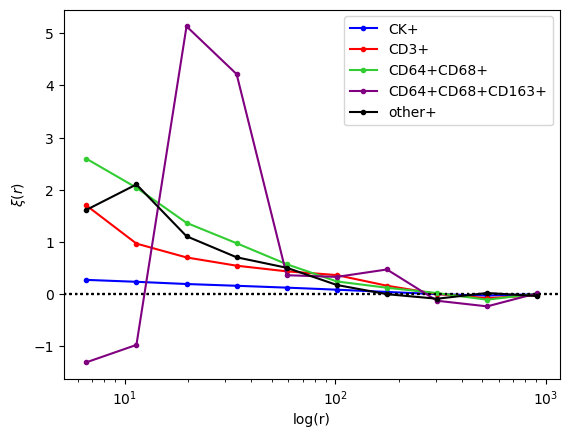

In [ ]:
plot_corr_overlaid(pp_dd_xi)

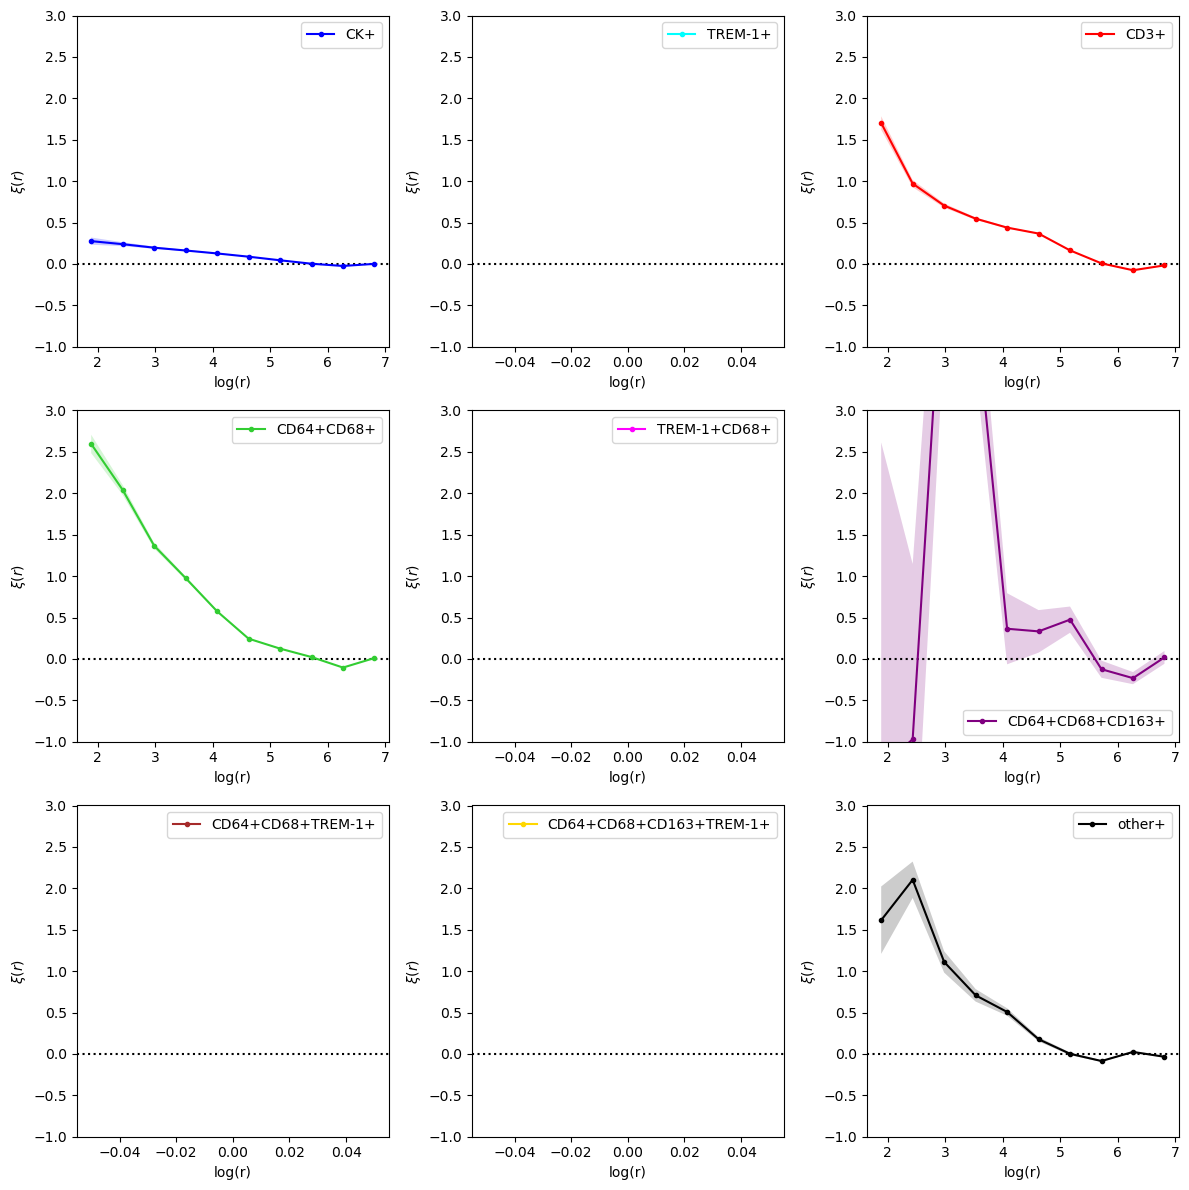

In [ ]:
plot_corr_separate(pp_dd_xi)

Cross-correlations between individual phenotypes and all cells.

In [ ]:
pd_rr_xi = crosscorrfn()

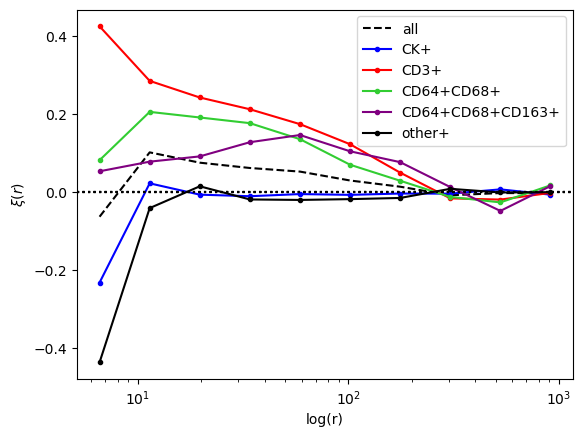

In [ ]:
plot_corr_overlaid(pd_rr_xi, plot_dd=True)

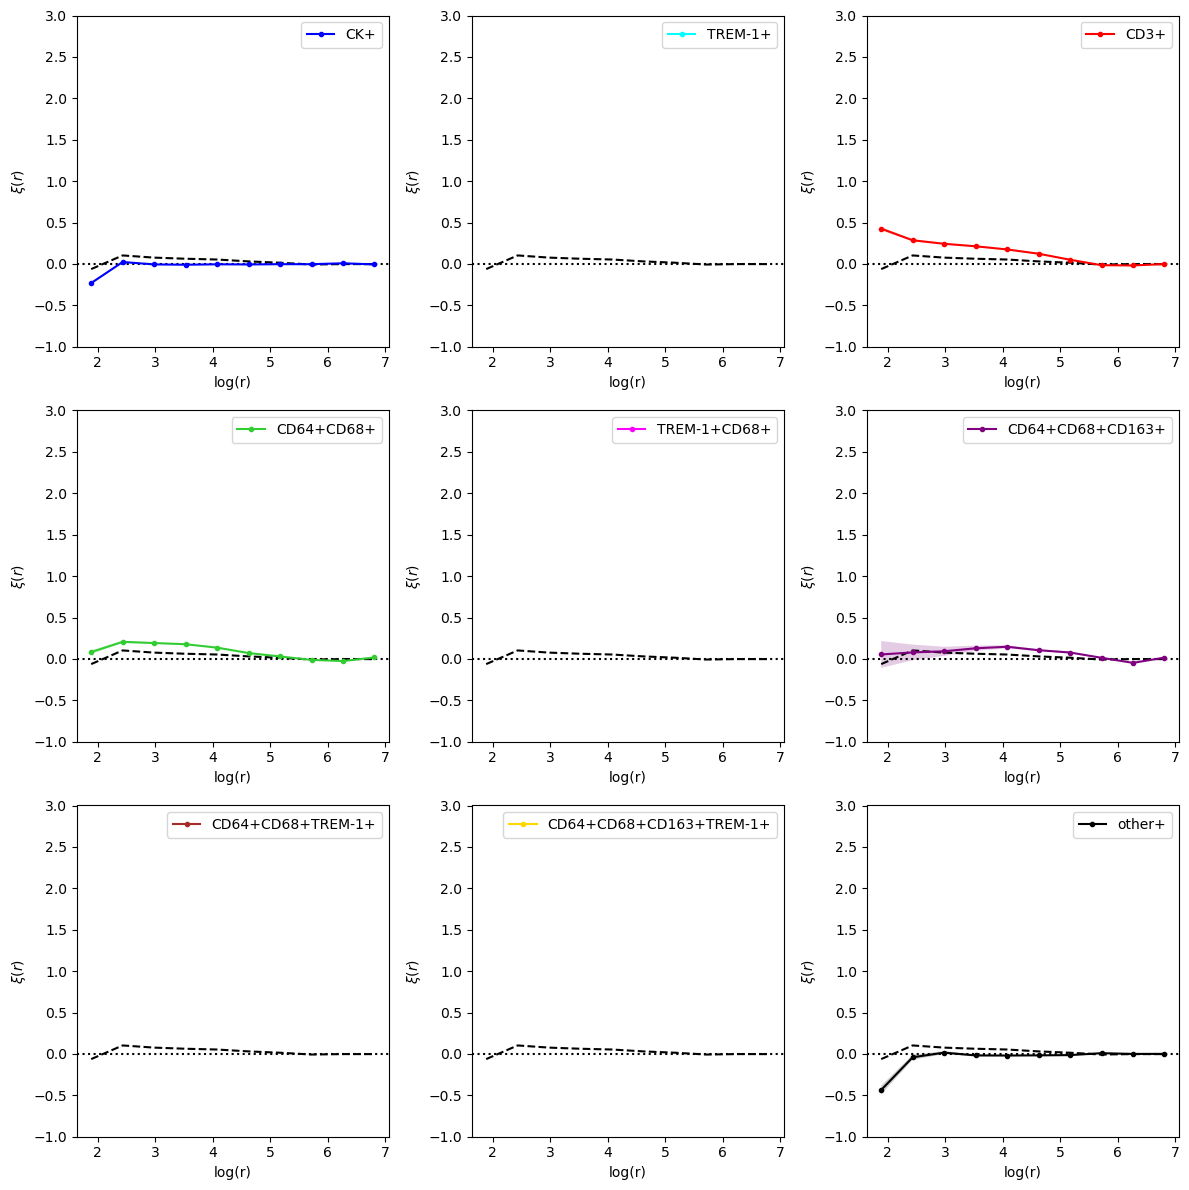

In [ ]:
plot_corr_separate(pd_rr_xi, plot_dd=True)

Cross-correlations between individual phenotypes and CD3+.

In [ ]:
pq_rr_xi = crosscorrfn(cross="CD3+")

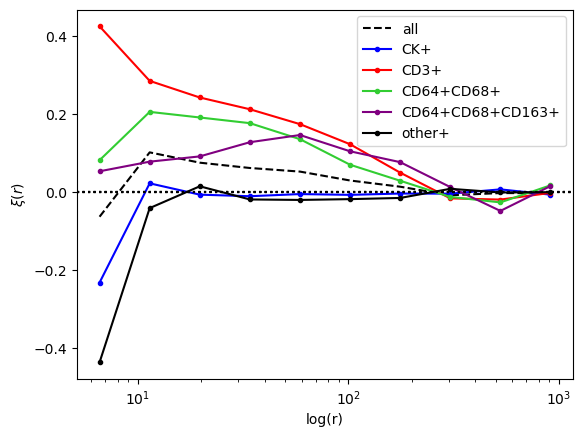

In [ ]:
plot_corr_overlaid(pd_rr_xi, plot_dd=True)

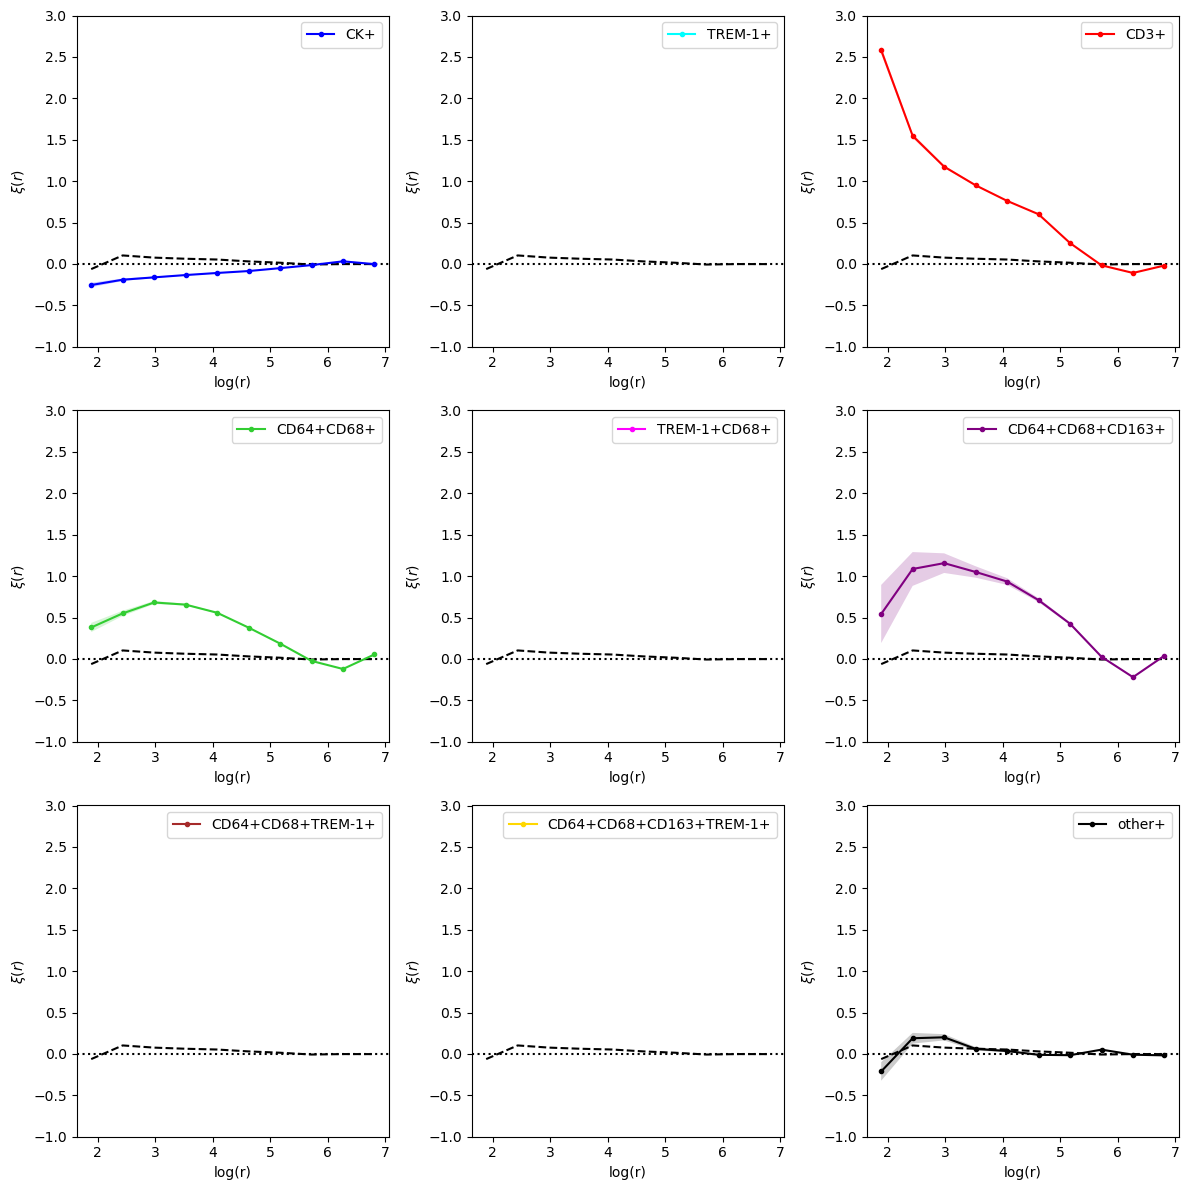

In [ ]:
plot_corr_separate(pq_rr_xi, plot_dd=True)